# Uncentainty plotter

This script uses the output of an depth-age model (e.g. Oxcal) to plot time series proxy records including age uncertainties. The fundamental approach is taken from COPRA [1]: 

The age uncertainty is obtained from multiple monte-carlo type depth-age model runs and expressed as a 95% confidence interval of possible ages per age interval. This uncertainty is then used to collect a sample of possible proxy values, that fall within this 95% age range based on the depth-age models' ensemble mean. A propability- (or alternatively a kernel-) density function can then be fitted to the sample of proxy values.

By iteratively repeating this fitting process to each time interval, a matrix of proxy propabilities can be generated, where each column represents the propability distribution of proxy values that arises from age uncertainty. In other words: the age uncertainty is projected onto the proxy axis.


[1] Breitenbach, S. F. M., Rehfeld, K., Goswami, B., Baldini, J. U. L., Ridley, H. E., Kennett, D. J., Prufer, K. M., Aquino, V. V., Asmerom, Y., Polyak, V. J., Cheng, H., Kurths, J., and Marwan, N.: COnstructing Proxy Records from Age models (COPRA), Clim. Past, 8, 1765–1779, https://doi.org/10.5194/cp-8-1765-2012


### We begin by collecting some packages

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

### Load sample data into a pandas dataframe:
The csv files contains the sample output from an OXCAL model run. The columns from left to right contain

- U/Th age of the ensemble mean
- U/Th time step 
- depth below surface
- incremental sedimentation amount
- age confidence interval, lower boundary
- age confidence interval, upper boundary
- sample depth of proxy
- proxy value ($\delta^{18}O$ in this case)

In [2]:
df = pd.read_csv('oxcal/KC05.csv')
df.head()

,UTh_t,UTh_dt,z,sed,from_95_4,to_95_4,zo18,o18
0,-3154.6,10.8,2.0,0.131,-3177,-3134,2.0,-3.4796
1,-3158.5,12.7,2.5,0.130,-3186,-3135,2.5,-3.0976
2,-3162.3,14.7,3.0,0.130,-3194,-3137,3.0,-3.8236
3,-3166.2,16.6,3.5,0.130,-3203,-3138,3.5,-3.3885
4,-3170.0,17.8,4.0,0.130,-3208,-3140,4.0,-3.3690


### Sampling function

In [3]:
def fit(sample, domain, KDE = False):
    
    '''This function fits a propability distribution of a 
    given sample within the bounds of a given domain. The 
    output can be either given as a Propability Density 
    Function (PDF by default) or as a Kernel Density 
    Estimate (if KDE = True).
    
    Returns a Tuple of the domain [0] and the requested 
    probability distribution.'''
    
    std = np.std(sample)
    mean = np.mean(sample)
    pdf = stats.norm.pdf(domain, mean, std)
    kde = stats.gaussian_kde(sample).evaluate(domain)
    
    if KDE == True:
        output = kde
    else:
        output = pdf
    
    return domain, output

To demonstrate what this function does, here's an example based on the entire dataset od $\delta^{18}O$ values drawn from the sample data

<IPython.core.display.Javascript object>


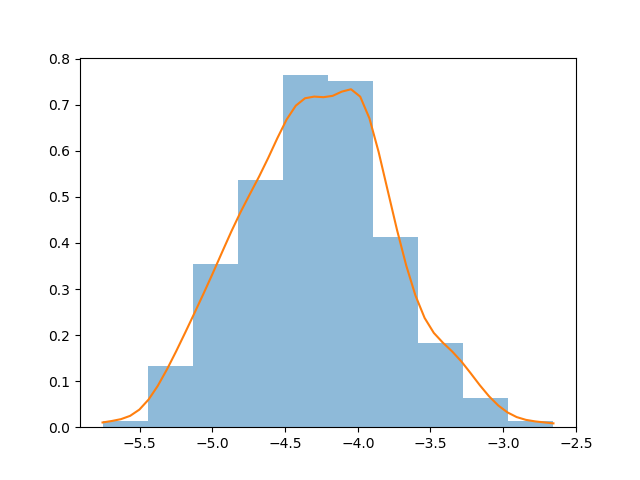

In [4]:
data = df.o18
domain = np.linspace(data.min(), data.max())

kde = fit(data, domain, KDE = True)

f, a = plt.subplots()
a.hist(df.o18, alpha=.5, density=True)
a.plot(kde[0],
       kde[1])

### Application

For each time interval of the depth-age model output, a sample of proxy values must be drawn, that contains the possible proxy values. The fitting function from above is the applied to this sample. The resulting distributions are collected in a numpy array.

The result is a matrix of probabilities of proxy values at each time interval (kde_field)

In [5]:
# global domain; the probability of all proxy values should be calculated to be consistent
g_domain = np.linspace(df.o18.min(), df.o18.max(), 500)

kde_field = [] # container variable to dump loop results in

for index, row in df.iterrows():
    
    # draw a sample of proxy values within the confidence interval
    condition = (df.UTh_t > row.from_95_4) & (df.UTh_t < row.to_95_4)
    sample = df.o18[condition]
    
    # apply the fit function
    # fit(...)[1] because we only need the actual distribution, not the domain
    kde = fit(sample, g_domain)[1] 
    kde_field.append(kde)
    

#convert output to a numpy array for easy handling 
kde_field = np.array(kde_field) 

### Plotting results

The resulting matrix can be plotted as a 2-D field. This is also where I failed to finish the job:

To make this useful as a Time-series plot, axes should not be labelled with row- and column numbers, but rather an age- and  proxy value scale. To make things more tricky, the time-steps from the depth-age model are not constant. a variable resolution along the time-axis is necessary.

<IPython.core.display.Javascript object>


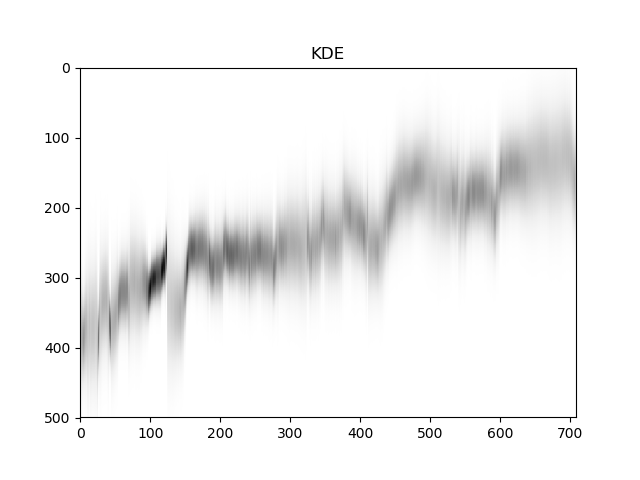

Text(0.5, 1.0, 'KDE')

In [6]:
f, a1 = plt.subplots()

a1.imshow(kde_field.T, cmap = 'Greys')
a1.set_title('KDE')

### This is what it should be

Here you see a simple plot of what the time series looks like without uncertainties. The idea is to basically have the plt.imshow() picture float in the background of this plot.

<IPython.core.display.Javascript object>


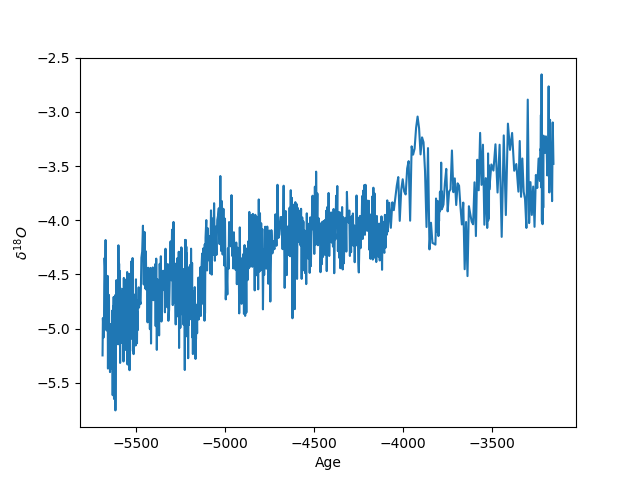

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0.5, 0, 'Age')

In [7]:
f, a1 = plt.subplots()
a1.plot(df.UTh_t,
        df.o18)
a1.set_ylabel(r'$\delta^{18}O$')
a1.set_xlabel(r'Age')